In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import mailbox

In [4]:
mboxfile = "/content/drive/MyDrive/Colab Datasets/All mail Including Spam and Trash (1).mbox"
mbox = mailbox.mbox(mboxfile)
mbox

In [5]:
for key in mbox[0].keys():
    print(key)

X-GM-THRID
X-Gmail-Labels
Delivered-To
Received
X-Google-Smtp-Source
X-Received
ARC-Seal
ARC-Message-Signature
ARC-Authentication-Results
Return-Path
Received
Received-SPF
Authentication-Results
DKIM-Signature
DKIM-Signature
From
Reply-To
To
Message-ID
Subject
MIME-Version
Content-Type
X-AMAZON-MAIL-RELAY-TYPE
Bounces-to
X-AMAZON-METADATA
X-Original-MessageID
Date
X-SES-Outgoing
Feedback-ID


In [6]:
import csv

In [7]:
with open('mailbox.csv', 'w') as outputfile:
    writer =  csv.writer(outputfile)
    writer.writerow(['Subject', 'date', 'to', 'label','thread'])
    for message in mbox:
        writer.writerow([
            message['subject'],
            message['from'],
            message['date'],
            message['to'],
            message['X-Gmail_Labels'],
            message['X-GM-THRID'],
        ]
    )

In [8]:
dfs = pd.read_csv('mailbox.csv', names=['subject', 'from', 'date', 'label', 'thread'])

In [9]:
dfs.dtypes

subject    object
from       object
date       object
label      object
thread     object
dtype: object

In [10]:
dfs.head()

,subject,from,date,label,thread
0,Subject,date,to,label,thread
1,Your Amazon.in order #408-7658831-2521108 of 1...,"""Amazon.in"" <auto-confirm@amazon.in>","Sat, 5 Dec 2020 12:49:21 +0000",brahmag15@gmail.com,NaN
2,"=?UTF-8?Q?The_Wire_shared_""To_Spend_Less_to_P?...",Twitter <info@twitter.com>,"Mon, 07 Dec 2020 07:50:54 +0000",Brahmjeet Gautam <brahmag15@gmail.com>,NaN
3,Re: wanted to send this your way Azmuth,Serge Ramelli <photoserge@z.kajabimail.net>,"Mon, 07 Dec 2020 21:46:25 +0000",brahmag15@gmail.com,NaN
4,Here's what people are saying,Snaphunt <contact@snaphunt.com>,"Fri, 20 Nov 2020 08:00:08 +0000 (UTC)",brahmag15@gmail.com,NaN


In [11]:
dfs['date'] = dfs['date'].apply(lambda x: pd.to_datetime(x, errors='coerce', utc=True))

In [12]:
dfs = dfs[dfs['date'].notna()]

In [13]:
dfs.to_csv('gmail.csv')

In [14]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1952 entries, 1 to 1952
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype              
---  ------   --------------  -----              
 0   subject  1952 non-null   object             
 1   from     1952 non-null   object             
 2   date     1952 non-null   datetime64[ns, UTC]
 3   label    1951 non-null   object             
 4   thread   0 non-null      object             
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 91.5+ KB


In [15]:
dfs.head(10)

,subject,from,date,label,thread
1,Your Amazon.in order #408-7658831-2521108 of 1...,"""Amazon.in"" <auto-confirm@amazon.in>",2020-12-05 12:49:21+00:00,brahmag15@gmail.com,NaN
2,"=?UTF-8?Q?The_Wire_shared_""To_Spend_Less_to_P?...",Twitter <info@twitter.com>,2020-12-07 07:50:54+00:00,Brahmjeet Gautam <brahmag15@gmail.com>,NaN
3,Re: wanted to send this your way Azmuth,Serge Ramelli <photoserge@z.kajabimail.net>,2020-12-07 21:46:25+00:00,brahmag15@gmail.com,NaN
4,Here's what people are saying,Snaphunt <contact@snaphunt.com>,2020-11-20 08:00:08+00:00,brahmag15@gmail.com,NaN
5,Live Webinar: How I solved the one problem tha...,Serge Ramelli <photoserge@z.kajabimail.net>,2020-12-04 12:19:28+00:00,brahmag15@gmail.com,NaN
6,=?UTF-8?Q?Yogendra_Yadav_Tw?= =?UTF-8?Q?eeted:...,Twitter <info@twitter.com>,2020-12-07 13:06:39+00:00,Brahmjeet Gautam <brahmag15@gmail.com>,NaN
7,HALF price - FULL benefits. Join now!,"""Freeletics"" <instructors@email.freeletics.com>",2020-11-18 08:32:37+00:00,brahmag15@gmail.com,NaN
8,=?UTF-8?B?WW9nZW5kcmEgWWFkYXYgc2g=?=\r\n =?UTF...,Twitter <info@twitter.com>,2020-12-06 02:36:00+00:00,Brahmjeet Gautam <brahmag15@gmail.com>,NaN
9,Current MADS student began data science journe...,"""Coursera"" <no-reply@m.mail.coursera.org>",2020-11-18 21:12:31+00:00,""""" <brahmag15@gmail.com>",NaN
10,=?utf-8?q?Introducing=3A_Zero_To_PRO_=F0=9F=A4...,Serge Ramelli <photoserge@z.kajabimail.net>,2020-11-21 16:25:28+00:00,brahmag15@gmail.com,NaN


In [16]:
import re

In [17]:
def extract_email_ID(string):
    email = re.findall(r'<(.+?)>', string)
    if not email:
        email = list(filter(lambda y: '@' in y, string.split()))
    return email[0] if email else np.nan

In [18]:
dfs['from'] = dfs['from'].apply(lambda x: extract_email_ID(x))

In [19]:
myemail = 'brahmag15@gmail.com'
dfs['label'] = dfs['from'].apply(lambda x: 'sent' if x==myemail else 'inbox')

In [20]:
dfs.columns

Index(['subject', 'from', 'date', 'label', 'thread'], dtype='object')

In [21]:
dfs.head()

,subject,from,date,label,thread
1,Your Amazon.in order #408-7658831-2521108 of 1...,auto-confirm@amazon.in,2020-12-05 12:49:21+00:00,inbox,NaN
2,"=?UTF-8?Q?The_Wire_shared_""To_Spend_Less_to_P?...",info@twitter.com,2020-12-07 07:50:54+00:00,inbox,NaN
3,Re: wanted to send this your way Azmuth,photoserge@z.kajabimail.net,2020-12-07 21:46:25+00:00,inbox,NaN
4,Here's what people are saying,contact@snaphunt.com,2020-11-20 08:00:08+00:00,inbox,NaN
5,Live Webinar: How I solved the one problem tha...,photoserge@z.kajabimail.net,2020-12-04 12:19:28+00:00,inbox,NaN


In [22]:
import datetime
import pytz

In [23]:
def refactor_timezone(x):
  ind = pytz.timezone('Asia/Kolkata')
  return x.astimezone(ind)

In [24]:
dfs['date'] = dfs['date'].apply(lambda x: refactor_timezone(x))

In [25]:
dfs['dayofweek'] = dfs['date'].dt.day_name
dfs['dayofweek'] = pd.Categorical(dfs['dayofweek'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday'], ordered=True)

In [26]:
dfs['timeofday'] = dfs['date'].apply(lambda x: x.hour + x.minute/60 + x.second/3600)

In [27]:
dfs['hour'] = dfs['date'].apply(lambda x: x.hour)

In [28]:
dfs['year_int'] = dfs['date'].apply(lambda x: x.year)

In [29]:
dfs['year'] = dfs['date'].apply(lambda x: x.year + x.dayofyear/365.25)

In [30]:
dfs.index = dfs['date']
del dfs['date']

In [32]:
print(dfs.index.min().strftime('%a, %d %b %Y %I %M %p'))
print(dfs.index.max().strftime('%a, %d %b %Y %I %M %p'))
print(dfs['label'].value_counts())

Sun, 27 Mar 2016 10 01 AM
Tue, 08 Dec 2020 09 24 PM
inbox    1951
sent        1
Name: label, dtype: int64


In [33]:
sent = dfs[dfs['label']=='sent']
received = dfs[dfs['label'] == 'inbox']

In [34]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy import ndimage
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

In [39]:
from wordcloud import WordCloud
df_no_arxiv = dfs[dfs['from'] != 'no-reply@arXiv.org']
text = ' '.join(map(str, sent['subject'].values))

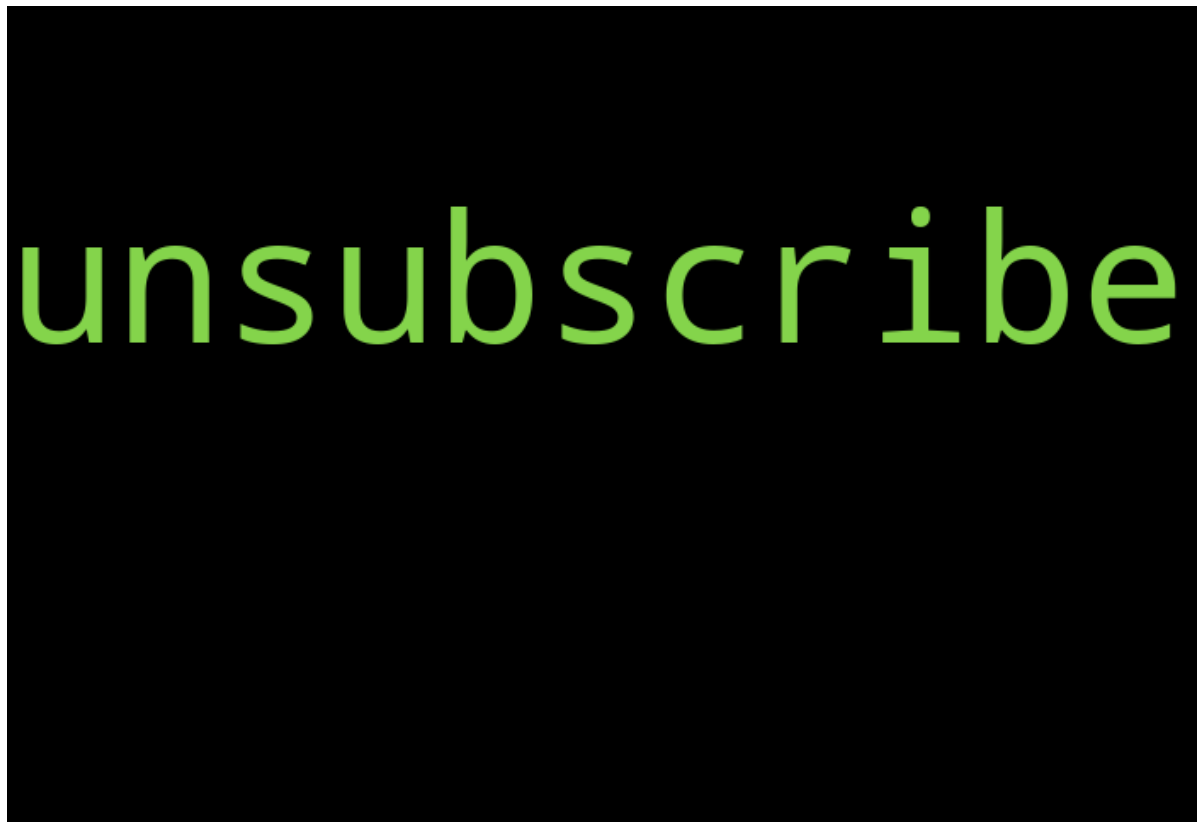

In [40]:
stopwords = ['Re', 'Fwd', '3A_']
wrd = WordCloud(width=700, height=480, margin=0, collocations=False)
for sw in stopwords:
  wrd.stopwords.add(sw)
wordcloud = wrd.generate(text)

plt.figure(figsize=(25,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)